In [1]:
%matplotlib inline

from os.path import join

import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
vgg_model = models.vgg19(pretrained=True)

In [3]:
vgg_features = vgg_model.features

In [4]:
for param in vgg_features.parameters():
    param.requires_grad_(False)

In [5]:
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [7]:
vgg_features.to(device)
print()

In [8]:
def load_image(img_path, max_size, shape=None):
    image = Image.open(img_path).convert('RGB')
    size = max(image.size)
    if size > max_size:
        size = max_size
        
    if shape is not None:
        size = shape
    
    img_transformations = transforms.Compose([
                                                transforms.Resize(size),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                            ])
    
    image = img_transformations(image).unsqueeze(0)
    
    return image

In [9]:
def img_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze(0)
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [10]:
content = load_image(join('my_photos', 'IMG_6662.jpg'), 400).to(device)
style = load_image(join('my_style', 'garold1.jpg'), 400, shape=content.shape[-2:]).to(device)

In [12]:
#content = load_image(join('Images', 'City.jpg'), 400).to(device)
#style = load_image(join('Images', 'StarryNight.jpg'), 400, shape=content.shape[-2:]).to(device)

(-0.5, 599.5, 399.5, -0.5)

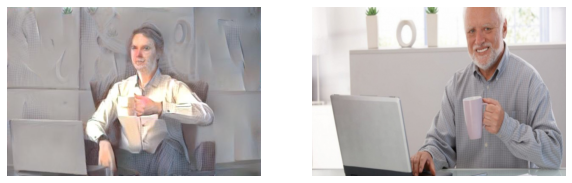

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
ax1.imshow(img_convert(content))
ax1.axis('off')
ax2.imshow(img_convert(style))
ax2.axis('off')

In [14]:
def get_features(image, model):
    target_layer_pos_to_name = {'0': 'conv1_1',
                               '5' : 'conv2_1',
                               '10': 'conv3_1',
                               '19': 'conv4_1',
                               '21': 'conv4_2', # context extraction
                               '28': 'conv5_1'}
    
    features = {}
    
    tensor = image
    
    for name, layer in model._modules.items():
        tensor = layer(tensor)
        if name in target_layer_pos_to_name:
            features[target_layer_pos_to_name[name]] = tensor
            
    return features

In [15]:
content_features = get_features(content, vgg_features)
style_features = get_features(style, vgg_features)

In [16]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [17]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [18]:
style_weights = {'conv1_1': 1.0, 
                 'conv2_1': 0.75, 
                 'conv3_1': 0.2, 
                 'conv4_1': 0.2, 
                 'conv5_1': 0.2}

content_weight = 1.0 # alpha
style_weight = 1e6 # beta

In [19]:
target = content.clone().requires_grad_(True).to(device)

In [20]:
show_every = 300
optimizer = optim.Adam([target], lr = 0.003)
steps = 5000

height, width, channels = img_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps / 300
counter = 0

Total loss:  25616.693359375
Iteration:  300


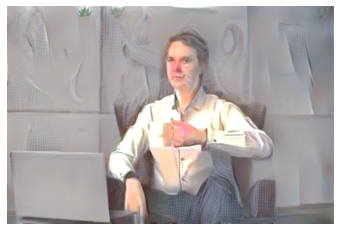

Total loss:  18682.560546875
Iteration:  600


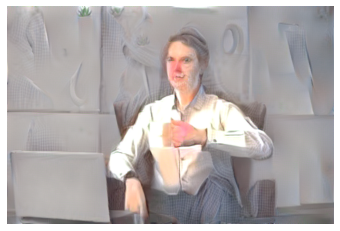

Total loss:  15095.1396484375
Iteration:  900


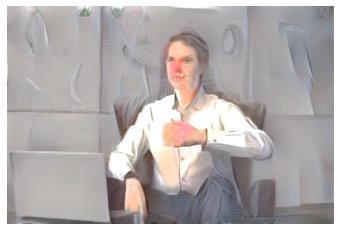

Total loss:  13314.359375
Iteration:  1200


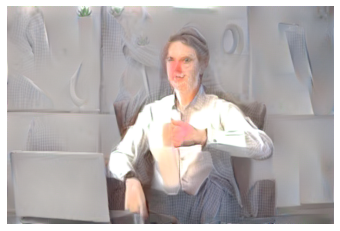

Total loss:  11891.5029296875
Iteration:  1500


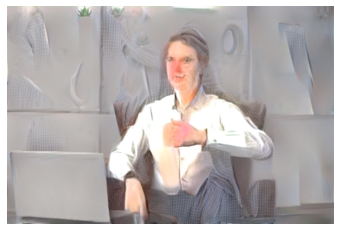

Total loss:  10967.4521484375
Iteration:  1800


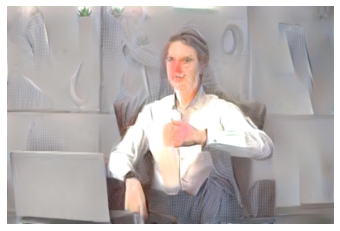

Total loss:  10097.6064453125
Iteration:  2100


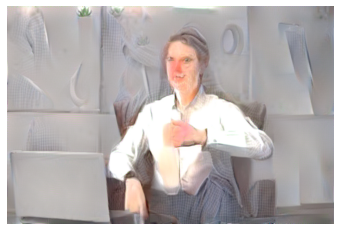

Total loss:  9178.53125
Iteration:  2400


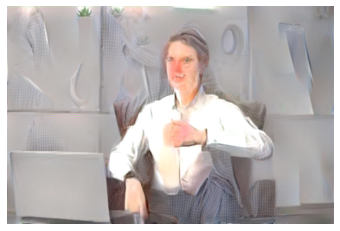

Total loss:  8526.7353515625
Iteration:  2700


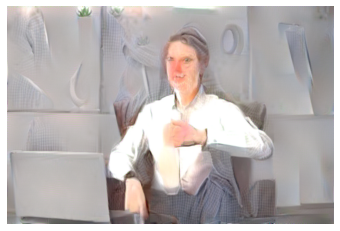

Total loss:  8012.22607421875
Iteration:  3000


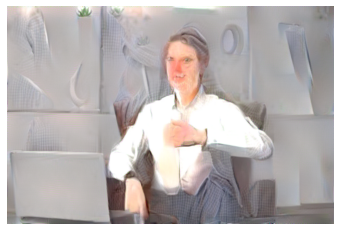

Total loss:  7523.0400390625
Iteration:  3300


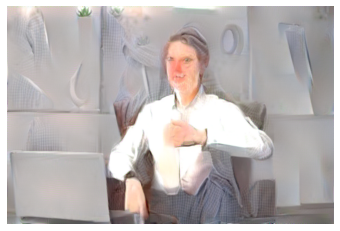

Total loss:  7401.68505859375
Iteration:  3600


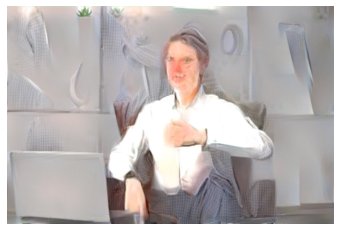

Total loss:  6836.89697265625
Iteration:  3900


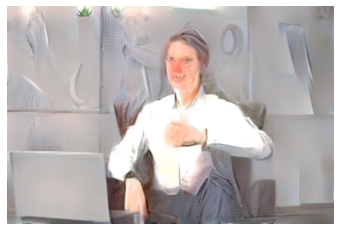

Total loss:  6531.61962890625
Iteration:  4200


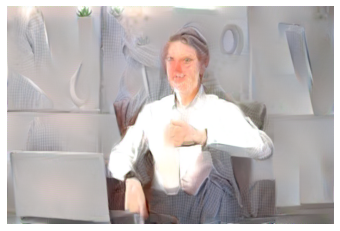

Total loss:  6298.58056640625
Iteration:  4500


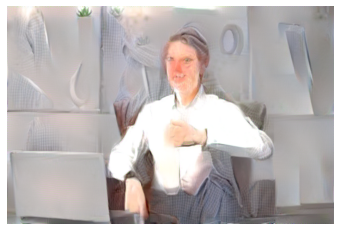

Total loss:  6042.55712890625
Iteration:  4800


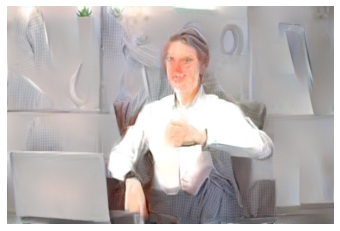

In [21]:
for ii in range(1, steps + 1):
    target_features = get_features(target, vgg_features)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    style_loss = 0.0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        print('Iteration: ', ii)
        plt.imshow(img_convert(target))
        plt.axis('off')
        plt.show()
        
    if ii % capture_frame == 0:
        image_array[counter] = img_convert(target)
        counter += 1

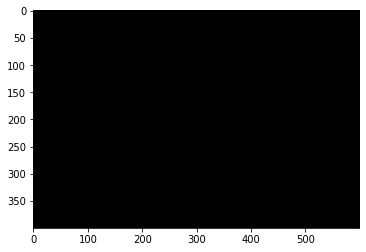

In [35]:
plt.imshow(image_array[0])